In [49]:
import os
from scipy.stats import norm
import numpy as np
from numpy import linalg as LA
from loguru import logger
import math


from federated_learning.arguments import Arguments
from federated_learning.dimensionality_reduction import calculate_pca_of_gradients
from federated_learning.parameters import get_layer_parameters
from federated_learning.parameters import calculate_parameter_gradients
from federated_learning.utils import get_model_files_for_epoch
from federated_learning.utils import get_model_files_for_suffix
from federated_learning.utils import apply_standard_scaler
from federated_learning.utils import get_poisoned_worker_ids_from_log
from federated_learning.utils import get_worker_num_from_model_file_name
from client import Client

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [284]:
# HYPERPARAMS FOR DEFENSE 

args = Arguments(logger)
args.log() 

# Class to be considered
CLASS_NUM = 4

# Choose model path and log path here
MODELS_PATH = 'results/NZ_CIFAR_6/Nz_CIFAR_6_2010_models/'
EXP_INFO_PATH = 'results/NZ_CIFAR_6/logs/Nz_CIFAR_6_2010.log'

# Which epochs to consider
EPOCHS = list(range(10, 200)) 

if 'FMNIST' in MODELS_PATH:
    LAYER_NAME = "fc.weight"
else:
    LAYER_NAME = "fc2.weight"
print(LAYER_NAME)

POISONED_WORKER_IDS = get_poisoned_worker_ids_from_log(EXP_INFO_PATH, line_num=32)
MODEL_FILES = sorted(os.listdir(MODELS_PATH))

2020-12-01 13:44:48.463 | DEBUG    | federated_learning.arguments:log:193 - Arguments: 
Batch Size: 10
Test Batch Size: 1000
Epochs: 200
Learning Rate: 0.01
Momentum: 0.5
CUDA Enabled: False
Shuffle Enabled: False
Log Interval: 100
Scheduler Step Size: 50
Scheduler Gamma: 0.5
Scheduler Minimum Learning Rate: 1e-10
Client Selection Strategy: None
Client Selection Strategy Arguments: null
Model Saving Enabled: True
Model Saving Interval: 1
Model Saving Path (Relative): models
Epoch Save Start Prefix: start
Epoch Save End Suffix: end
Number of Clients: 20
Number of Poisoned Clients: 10
NN: <class 'federated_learning.nets.cifar_10_cnn.Cifar10CNN'>
Train Data Loader Path: data_loaders/cifar10/train_data_loader.pickle
Test Data Loader Path: data_loaders/cifar10/test_data_loader.pickle
Loss Function: <class 'torch.nn.modules.loss.CrossEntropyLoss'>
Default Model Folder Path: default_models
Data Path: data



fc2.weight


## PCA Visualization

- Visualizes a dimensionality reduced version of gradients for a specific class across all agents
- It is noted that as gradients are accumulated over a range of epochs, malicious agent gradients are distinct from the benign ones 

In [281]:
# Utils functions for PCA Vizualization

def load_models(args, model_filenames):
    clients = []
    for model_filename in model_filenames:
        client = Client(args, 0, None, None)
        client.set_net(client.load_model_from_file(model_filename))

        clients.append(client)

    return clients



def plot_gradients_2d(gradients, attack_type='Noise'):
    fig = plt.figure(figsize=(10,8))
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Malicious', markerfacecolor='red',markersize=15),
        Line2D([0], [0], marker='o', color='w', label='Benign', markerfacecolor='blue', markersize=15)
    ]

    for (worker_id, gradient) in gradients:
        if worker_id in POISONED_WORKER_IDS:
            plt.scatter(gradient[0], gradient[1], color="red", s=10, alpha=0.8)
        else:
            plt.scatter(gradient[0], gradient[1], color="blue", s=10, alpha=0.4)
    
    fig.legend(handles=legend_elements, loc='best')
    plt.grid(True)
    plt.title(f'{attack_type} Attack - Class {CLASS_NUM}')

2020-12-01 13:42:43.420 | INFO     | federated_learning.dimensionality_reduction.pca:calculate_pca_of_gradients:6 - Computing 2-component PCA of gradients
/home/deepandas11/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


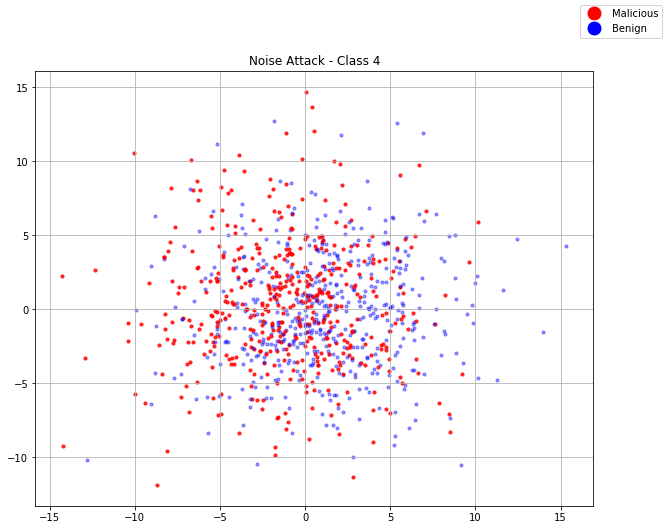

In [283]:
# PCA viz - Flip Flag to run
if False:
    param_diff = []
    worker_ids = []
    for epoch in EPOCHS:
        start_model_files = get_model_files_for_epoch(MODEL_FILES, epoch)
        start_model_file = get_model_files_for_suffix(start_model_files, args.get_epoch_save_start_suffix())[0]
        start_model_file = os.path.join(MODELS_PATH, start_model_file)
        start_model = load_models(args, [start_model_file])[0]
        start_model_layer_param = list(get_layer_parameters(start_model.get_nn_parameters(), LAYER_NAME)[CLASS_NUM])

        end_model_files = get_model_files_for_epoch(MODEL_FILES, epoch)
        end_model_files = get_model_files_for_suffix(end_model_files, args.get_epoch_save_end_suffix())

        for end_model_file in end_model_files:
            worker_id = get_worker_num_from_model_file_name(end_model_file)
            end_model_file = os.path.join(MODELS_PATH, end_model_file)
            end_model = load_models(args, [end_model_file])[0]


            end_model_layer_param = list(get_layer_parameters(end_model.get_nn_parameters(), LAYER_NAME)[CLASS_NUM])

            gradient  = calculate_parameter_gradients(logger, start_model_layer_param, end_model_layer_param)
            gradient = gradient.flatten()
            l2_norm = sum([item**2 for item in gradient])
            param_diff.append(gradient)
            worker_ids.append(worker_id)



    scaled_param_diff = apply_standard_scaler(param_diff)
    dim_reduced_gradients = calculate_pca_of_gradients(logger, scaled_param_diff, 2)
    plot_gradients_2d(zip(worker_ids, dim_reduced_gradients))


## Gradient Norm Visualization

- Find average gradient for all clients across all epochs
- Notice if there are differences in the norms
- Try out L2, L-inf, Signed L2 norms

In [328]:
# Helper functions for NORM visualization

def signed_norm(vec):
    sign = lambda x : 1 if x>=0 else -1
    ssum = sum([sign(item)*item**2 for item in vec])
    return math.sqrt(sign(ssum) * ssum)
    

def find_epochwise_stats(EPOCHS=EPOCHS, MODEL_FILES=MODEL_FILES):
    """
    Finds the average grad-norms for a client in whatever epoch it is chosen across all classes
    """
    epochwise_stats = {}
    for epoch in EPOCHS:
        start_model_files = get_model_files_for_epoch(MODEL_FILES, epoch)
        start_model_file = get_model_files_for_suffix(start_model_files, args.get_epoch_save_start_suffix())[0]
        start_model_file = os.path.join(MODELS_PATH, start_model_file)
        start_model = load_models(args, [start_model_file])[0]

        end_model_files = get_model_files_for_epoch(MODEL_FILES, epoch)
        end_model_files = get_model_files_for_suffix(end_model_files, args.get_epoch_save_end_suffix())
        curr_epoch = {}
        # Each end model file represents a worker chosen for that epoch
        for end_model_file in end_model_files:
            worker_dict = {}
            worker_id = get_worker_num_from_model_file_name(end_model_file)
            end_model_file = os.path.join(MODELS_PATH, end_model_file)
            end_model = load_models(args, [end_model_file])[0]
            
            # Update gradient norms for each class for the current client
            l2s, lis, lsns = [], [], []
            for class_num in range(10):
                start_model_layer_param = list(get_layer_parameters(start_model.get_nn_parameters(), LAYER_NAME)[class_num])
                end_model_layer_param = list(get_layer_parameters(end_model.get_nn_parameters(), LAYER_NAME)[class_num])
                gradient  = calculate_parameter_gradients(logger, start_model_layer_param, end_model_layer_param)
                gradient = gradient.flatten()
                l2, li, ls = LA.norm(np.array(gradient)), LA.norm(np.array(gradient), np.inf), signed_norm(gradient)
                l2s.append(l2)
                lis.append(li)
                lsns.append(ls)
            curr_epoch[worker_id] = {'L2' : l2s, 'L_inf': lis, 'LSNS': lsns}
        epochwise_stats[epoch] = curr_epoch
        
    return epochwise_stats

def find_worker_stats(epochwise_stats, norm='L2', EPOCHS=EPOCHS):
    """
    Accumulates classwise gradnorms for a client across all epochs based on norm type
    """
    all_workers = {i: [] for i in range(50)}
    for epoch in EPOCHS:
        curr_epoch = epochwise_stats[epoch]
        for wid in curr_epoch:
            all_workers[wid].append(curr_epoch[wid][norm])
    
    for wid in all_workers:
        all_workers[wid] = np.array(all_workers[wid])
        
    return all_workers


def visualize_grad_norm(stats, poisoned_ids=POISONED_WORKER_IDS):
    
    legend_elements = [
            Line2D([0], [0], marker='o', color='r', label='Poisoned', markerfacecolor='red', markersize=15),
            Line2D([0], [0], marker='o', color='b', label='Benign', markerfacecolor='blue', markersize=15),
            Line2D([0], [0], marker='o', color='g', label='Mean', markerfacecolor='green', markersize=15)
    ]
    
    new_stats = {
        'L2' : find_worker_stats(stats, 'L2'),
        'L_inf' : find_worker_stats(stats, 'L_inf'),
        'L2_signed' : find_worker_stats(stats, 'LSNS')
    
    }
    fig, axs = plt.subplots(1, 3, figsize=(30,10))
    for i, norm_type in enumerate(new_stats):
        norm_average = []        
        for wid in new_stats[norm_type]:
            if len(new_stats[norm_type][wid]) == 0:
                continue
            col = 'r' if wid in poisoned_ids else 'b'
            alpha = 0.6 if wid in poisoned_ids else 0.3
            mean_vec = np.mean(new_stats[norm_type][wid], 0)

            axs[i].plot(mean_vec, col, alpha=alpha)
            norm_average.append(mean_vec)
            axs[i].set_xlabel('Class Number')
            axs[i].set_ylabel(f'Gradient Norm')
            axs[i].set_title(f'Norm Type {norm_type}')
            axs[i].grid(True)
        
        na_mean, na_std = np.mean(np.array(norm_average), 0), np.std(np.array(norm_average), 0)
#         print(na_mean)
#         nmean, nstd = [na_mean for _ in range(10)], [na_std for _ in range(10)]
#         axs[i].plot(nmean, 'g')      
        axs[i].plot(na_mean, 'g', linestyle='--', linewidth=7, alpha=0.5)
        axs[i].legend(handles=legend_elements, loc='upper right')

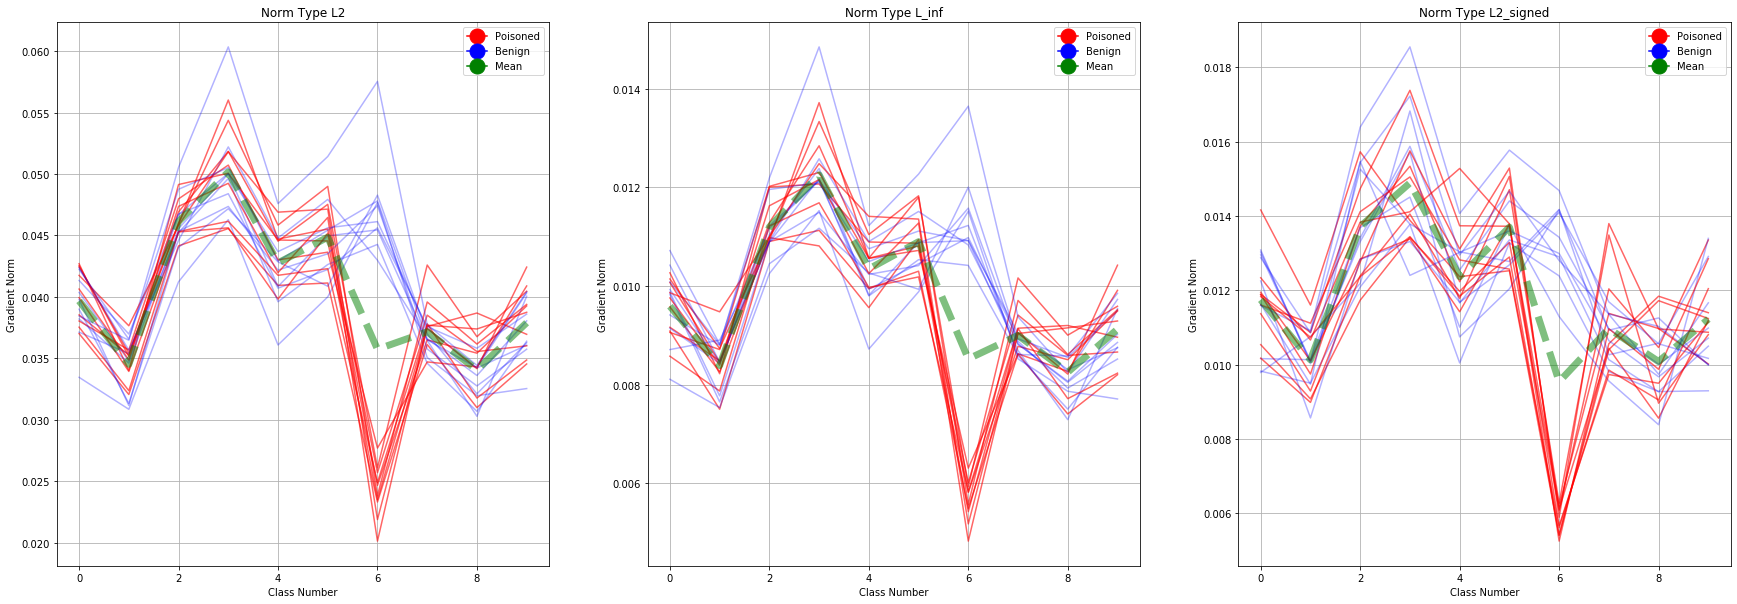

In [329]:
# Flip flag to find stats dictionary
if False:
    stats = find_overall_stats()
visualize_grad_norm(stats)